<a href="https://colab.research.google.com/github/shakasom/zonalstatistics/blob/master/Zonal_Statistics_Sentinel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Installations
!apt install gdal-bin python-gdal python3-gdal 
!pip install rasterio
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes

In [0]:
!pip install mapclassify

In [0]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
!wget https://www.dropbox.com/s/gf51dybqbujyjb2/Data.zip

In [0]:
!unzip Data.zip

In [0]:
b8 = rio.open("/content/Data/20191101/B08-20191101.tif")
b4 = rio.open("/content/Data/20191101/B04-20191101.tif")
b3 = rio.open("/content/Data/20191101/B03-20191101.tif")
b2 = rio.open("/content/Data/20191101/B02-20191101.tif")

In [6]:

b4.count, b4.width, b4.height

(1, 479, 429)

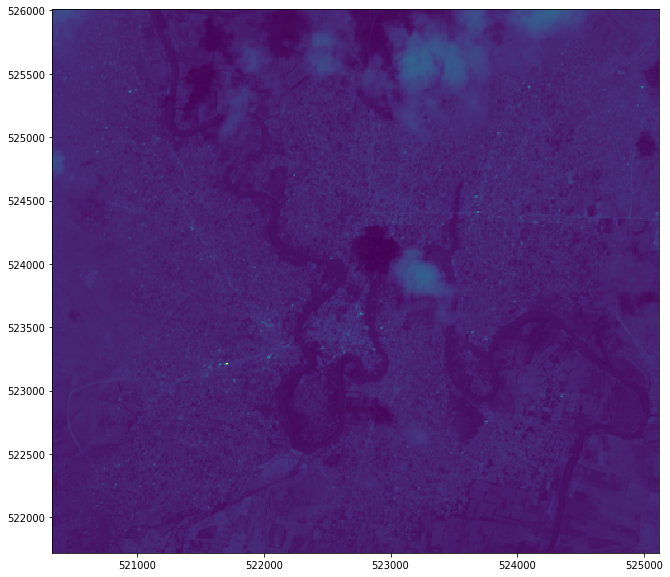

In [7]:
fig, ax = plt.subplots(1, figsize=(12, 10))
show(b3, ax=ax)
plt.show()

In [63]:
buildings = gpd.read_file("/content/Data/shapefiles/osm_buildings.shp")
buildings = buildings[["osm_id","building", "geometry"]]
buildings.head()


,osm_id,building,geometry
0,8275560,yes,"POLYGON ((521839.828 524323.388, 521837.607 52..."
1,8276697,yes,"POLYGON ((522700.756 523641.273, 522727.020 52..."
2,8280395,yes,"POLYGON ((523000.403 523492.953, 523003.418 52..."
3,None,yes,"POLYGON ((521087.015 523190.338, 521095.931 52..."
4,None,yes,"POLYGON ((521096.268 523212.801, 521104.110 52..."


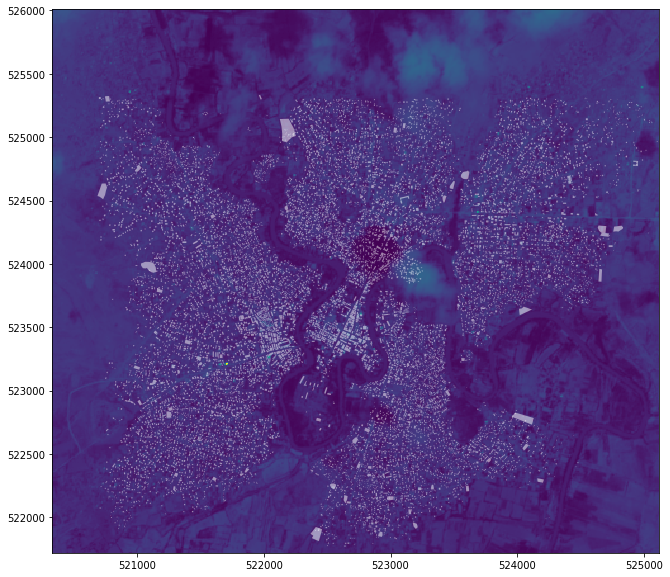

In [64]:
fig, ax = plt.subplots(figsize=(12, 10))
show(b4, ax=ax)
buildings.plot(ax=ax, color="white", alpha=.50)
plt.show();

## Calculate NDWI

In [0]:
green = b3.read()
nir = b8.read()
ndwi = (nir.astype(float)-green.astype(float))/(nir+green)

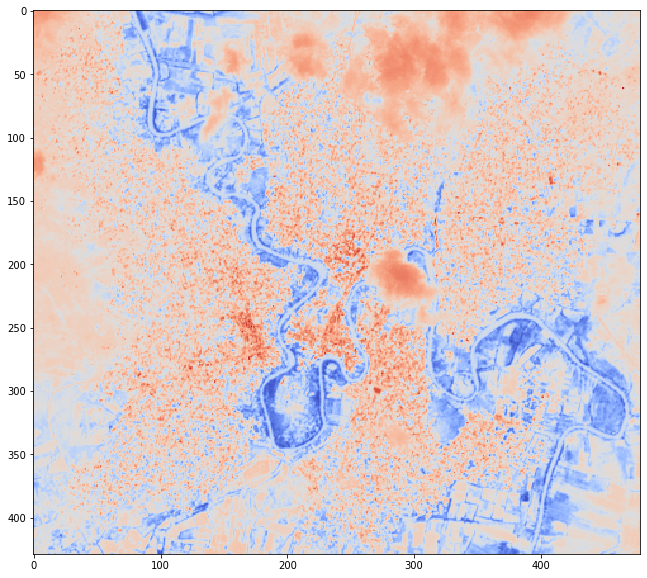

In [66]:
fig, ax = plt.subplots(1, figsize=(12, 10))
show(ndwi, ax=ax, cmap="coolwarm_r")
plt.show()

In [0]:
meta = b4.meta

meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

with rio.open('NDWI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rio.float32))

In [0]:
ndwi_raster = rio.open("NDWI.tif")

In [0]:
masked, mask_transform = mask(dataset=ndwi_raster, 
                              shapes=buildings.geometry, crop=True)

In [70]:
masked

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.06443004, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)

In [71]:
masked.mean()

0.008840306

In [72]:
masked.max()

0.62471396

In [73]:
b4.crs

CRS.from_epsg(32638)

In [74]:
buildings.crs

{'init': 'epsg:32638'}

In [0]:
 buildings = buildings.to_crs(ndvi_raster.crs)

In [0]:
def derive_stats(geom, data=ndwi_raster, **mask_kw):
    masked, mask_transform = mask(dataset=data, shapes=(geom,),
                                  crop=True, all_touched=True, filled=True)
    return masked

In [0]:
buildings['mean_ndwi'] = buildings.geometry.apply(derive_stats).apply(np.mean)

In [0]:
buildings['max_ndwi'] = buildings.geometry.apply(derive_stats).apply(np.max)

In [79]:
buildings.head()

,osm_id,building,geometry,mean_ndwi,max_ndwi
0,8275560,yes,"POLYGON ((521839.828 524323.388, 521837.607 52...",0.124131,0.214740
1,8276697,yes,"POLYGON ((522700.756 523641.273, 522727.020 52...",0.034564,0.242979
2,8280395,yes,"POLYGON ((523000.403 523492.953, 523003.418 52...",0.032114,0.132943
3,None,yes,"POLYGON ((521087.015 523190.338, 521095.931 52...",0.106921,0.174059
4,None,yes,"POLYGON ((521096.268 523212.801, 521104.110 52...",0.100953,0.138594


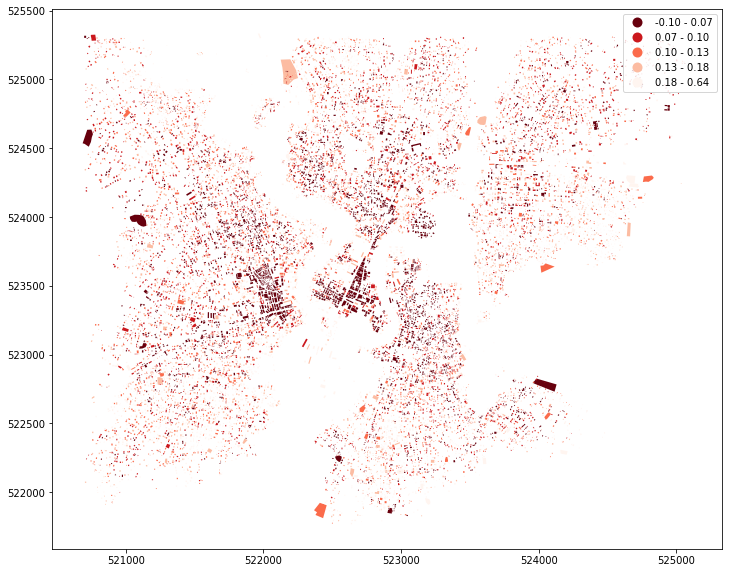

In [102]:
fig, ax = plt.subplots(figsize=(12,10))
buildings.plot(column="mean_ndwi", ax=ax, cmap="Reds_r", scheme='quantiles', legend=True)

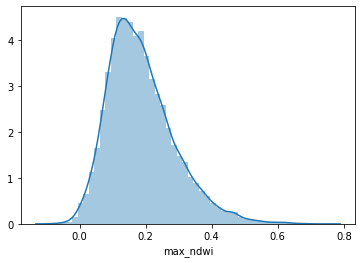

In [127]:
sns.distplot(buildings.max_ndwi)

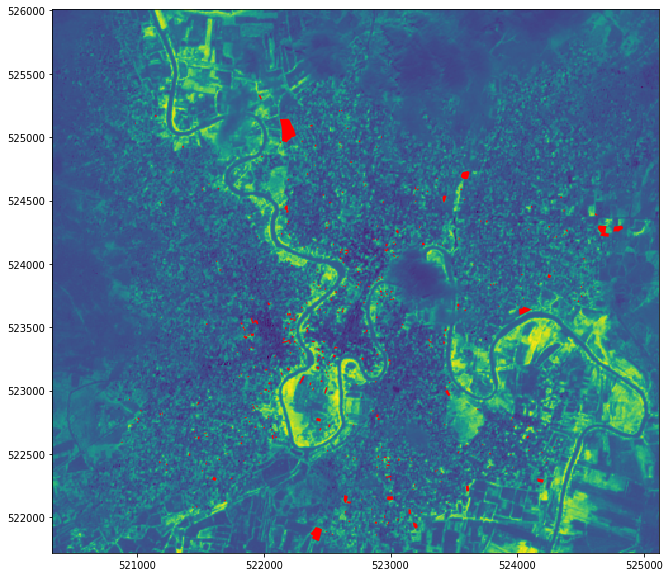

In [133]:
fig, ax = plt.subplots(figsize=(12, 10))
show(ndwi_raster, ax=ax)
buildings[buildings["max_ndwi"].between(0.4, 0.6)].plot(color="darkgreen", ax=ax)
plt.show();

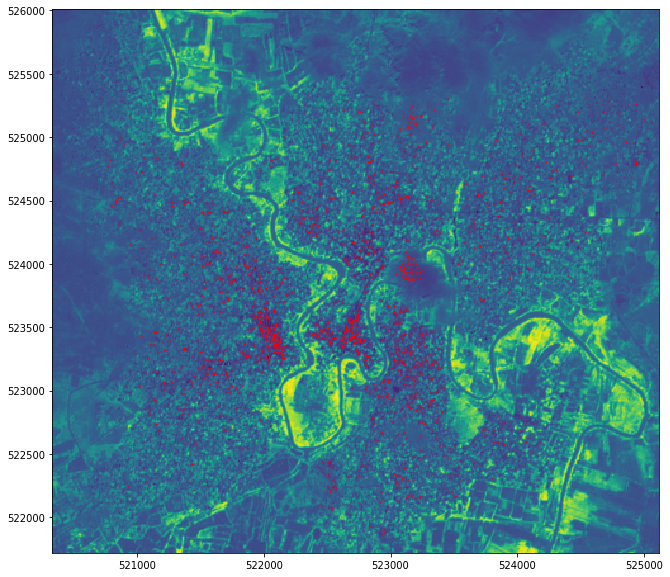

In [145]:
fig, ax = plt.subplots(figsize=(12, 10))
show(ndwi_raster, ax=ax)
buildings[buildings["max_ndwi"].between(0, 0.1)].plot(color="red", ax=ax)
plt.show();